In [6]:
from ttslearn.tacotron import Tacotron2TTS
from tqdm.notebook import tqdm
import soundfile as sf

engine = Tacotron2TTS()
wav, sr = engine.tts("", tqdm=tqdm)
sf.write("test.wav", wav, sr)

  0%|          | 0/39600 [00:00<?, ?it/s]

In [1]:
1/(256)**(0.5)

0.0625

/home/ynishimura/miniconda3/envs/vc_tts_template/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:128: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


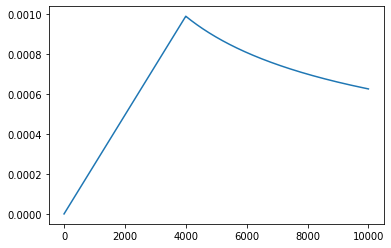

In [33]:
import torch
from vc_tts_template.fastspeech2 import FastSpeech2
from vc_tts_template.fastspeech2.optimizer import ScheduledOptim
import matplotlib.pyplot as plt
import numpy as np

model = FastSpeech2(
    max_seq_len=1000, num_vocab=52, encoder_hidden_dim=256, encoder_num_layer=2, encoder_num_head=2, conv_filter_size=256,
    conv_kernel_size=[9, 1], encoder_dropout=0.2, variance_predictor_filter_size=256, variance_predictor_kernel_size=5, variance_predictor_dropout=0.2,
    pitch_feature_level=1, energy_feature_level=1, pitch_quantization="linear", energy_quantization="linear",
    n_bins=256, decoder_hidden_dim=256, decoder_num_layer=4, decoder_num_head=2, decoder_dropout=0.2,
    n_mel_channel=80, multi_speaker=0, encoder_fix=False, stats={"pitch_min": 70, "pitch_max": 750, "energy_min": 10, "energy_max": 27}, 
    speakers=None
)

class ScheduledOptim_old:
    """ A simple wrapper class for learning rate scheduling """

    def __init__(self, optimizer, warm_up_step, anneal_steps, anneal_rate, current_step=0):

        self._optimizer = optimizer
        self.n_warmup_steps = warm_up_step
        self.anneal_steps = anneal_steps
        self.anneal_rate = anneal_rate
        self.current_step = current_step
        self.init_lr = 0.0625

    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        # print(self.init_lr)
        self._optimizer.zero_grad()

    def load_state_dict(self, path):
        self._optimizer.load_state_dict(path)

    def _get_lr_scale(self):
        lr = np.min(
            [
                np.power(self.current_step, -0.5),
                np.power(self.n_warmup_steps, -1.5) * self.current_step,
            ]
        )
        for s in self.anneal_steps:
            if self.current_step > s:
                lr = lr * self.anneal_rate
        return lr

    def _update_learning_rate(self):
        """ Learning rate scheduling per step """
        self.current_step += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group["lr"] = lr


optimizer_old = torch.optim.Adam(
            model.parameters(),
            betas=[0.9, 0.98],
            eps=0.000000001,
            weight_decay=0.0,
)
optimizer = torch.optim.Adam(
            model.parameters(),
            lr=0.0625,
            betas=[0.9, 0.98],
            eps=0.000000001,
            weight_decay=0.0,
)

# lr_scheduler_old = ScheduledOptim_old(optimizer_old, 4000, [300000, 400000, 500000], 0.3)
lr_scheduler = ScheduledOptim(4000, [300000, 400000, 500000], 0.3)
lr_scheduler._set_optimizer(optimizer)

# lrs_old = []
lrs_new = []

for _ in range(10000):
    # print("old current    step : ", lr_scheduler_old.current_step)
    # print("old current      lr : ", lr_scheduler_old._get_lr_scale() * lr_scheduler_old.init_lr)
    # print("old current  params : ", optimizer_old.param_groups[0]["lr"])
    # print("new current    step : ", lr_scheduler.last_epoch)
    # print("new current      lr : ", lr_scheduler.get_last_lr())
    # print("new current  params : ", optimizer.param_groups[0]["lr"])
    # print()
    # print("="*30)
    # lrs_old.append(optimizer_old.param_groups[0]["lr"])
    lrs_new.append(optimizer.param_groups[0]["lr"])

    # lr_scheduler_old.step_and_update_lr()
    lr_scheduler.step()

# plt.plot(lrs_old)
plt.plot(lrs_new)
plt.show()

In [34]:
torch.save(optimizer.state_dict(), "tmp.pth")
torch.save(lr_scheduler.state_dict(), "tmp_lr.pth")

Adam (
Parameter Group 0
    amsgrad: False
    betas: [0.9, 0.98]
    eps: 1e-09
    initial_lr: 0.0625
    lr: 0.0006249687523435547
    weight_decay: 0.0
)


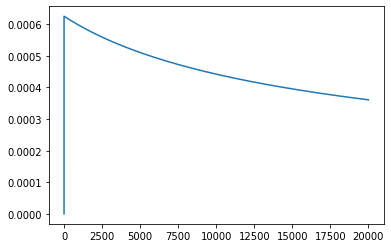

In [35]:
optimizer_new = torch.optim.Adam(
            model.parameters(),
            lr=0.0625,
            betas=[0.9, 0.98],
            eps=0.000000001,
            weight_decay=0.0,
)
optimizer_new.load_state_dict(torch.load("tmp.pth"))
print(optimizer_new)
lr_scheduler_ = ScheduledOptim(4000, [300000, 400000, 500000], 0.3)
lr_scheduler_._set_optimizer(optimizer_new)
lr_scheduler_.load_state_dict(torch.load("tmp_lr.pth"))

lrs_new_ = []

for _ in range(20000):
    lrs_new_.append(optimizer_new.param_groups[0]["lr"])
    lr_scheduler_.step()

plt.plot(lrs_new_)
plt.show()

In [ ]:
"""
結論
- 再現は意外と容易. last_epochと言いつつ, stepごとに更新される値を使って, get_lrを実装すればよいだけ.
- loadに関しては, lr_schedulerごと保存しないと意味がない. optimizerだけやっても, 最初から
lrのscheduleが始まるだけ.
"""